# 시계열 데이터 분석 : ytn 주식 분석

In [180]:
import folium
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import json
import googlemaps
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
import matplotlib.pyplot as plt
%matplotlib inline
import platform
import seaborn as sns
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family = 'AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system. sorry~~~')

import pandas_datareader.data as web
from fbprophet import Prophet
from datetime import datetime
from pandas_datareader import data
from konlpy.tag import Kkma
from konlpy.tag import Hannanum
from konlpy.tag import Twitter
from bs4 import BeautifulSoup
from urllib.request import urlopen
import urllib
import time 
from tqdm import tqdm_notebook
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

In [193]:
url='https://finance.naver.com/item/sise_day.nhn?code=040300'
df=pd.DataFrame()
for page in range(1,258):
    pg_url='{url}&page={page}'.format(url=url,page=page)
    df=df.append(pd.read_html(pg_url, header=0)[0], ignore_index=True)
df=df.dropna()
df.tail()

,날짜,종가,전일비,시가,고가,저가,거래량
3849,2010.01.11,4550.0,10.0,4580.0,4645.0,4525.0,33685.0
3850,2010.01.08,4560.0,30.0,4645.0,4645.0,4530.0,60409.0
3851,2010.01.07,4530.0,150.0,4665.0,4710.0,4525.0,90174.0
3852,2010.01.06,4680.0,5.0,4635.0,4700.0,4635.0,58466.0
3853,2010.01.05,4685.0,95.0,4785.0,4785.0,4665.0,79975.0


In [194]:
df['날짜']=pd.to_datetime(df['날짜'])
df.set_index('날짜', inplace=True)
df = df.sort_index()

# 1. ~2018.12.31일 까지의 시세를 확인하세요

In [195]:
df_origin =df

In [196]:
df_origin.tail()

,종가,전일비,시가,고가,저가,거래량
날짜,,,,,,
2020-05-29,1915.0,25.0,1960.0,1960.0,1815.0,93141.0
2020-06-01,1915.0,0.0,1900.0,1965.0,1880.0,90005.0
2020-06-02,1920.0,5.0,1915.0,1950.0,1910.0,15584.0
2020-06-03,1910.0,10.0,1920.0,1950.0,1890.0,85827.0
2020-06-04,1905.0,5.0,1915.0,1925.0,1875.0,129623.0


In [183]:
df = df.loc['2010.01.01':'2018.12.31']
df.tail()

,종가,전일비,시가,고가,저가,거래량
날짜,,,,,,
2018-12-21,2010.0,10.0,2035.0,2035.0,2000.0,17066.0
2018-12-24,2075.0,65.0,2010.0,2090.0,1995.0,126563.0
2018-12-26,2010.0,65.0,2070.0,2070.0,1975.0,86418.0
2018-12-27,2020.0,10.0,2050.0,2050.0,2015.0,18482.0
2018-12-28,2100.0,80.0,2065.0,2105.0,2005.0,77974.0


# 2. 1.의 기간의 종가(close)를 기준으로 그래프를 그려라

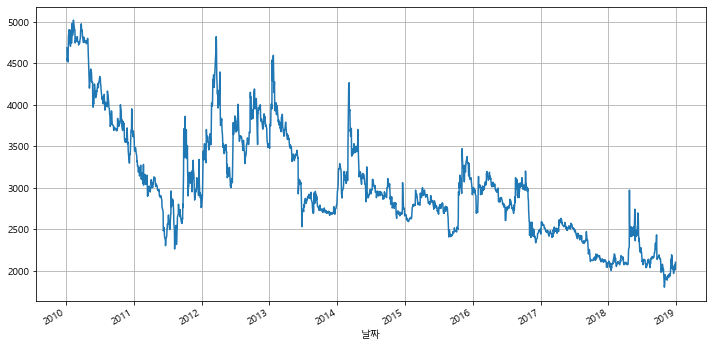

In [184]:
df['종가'].plot(figsize=(12,6), grid=True);

In [185]:
f=pd.DataFrame({'ds':df.index, 'y':df['종가']})
f.reset_index(inplace=True)
del f['날짜']
f.head()

,ds,y
0,2010-01-05,4685.0
1,2010-01-06,4680.0
2,2010-01-07,4530.0
3,2010-01-08,4560.0
4,2010-01-11,4550.0


# 3. 1년 후 2019.12.31일 까지의 정보를 예측해보시오

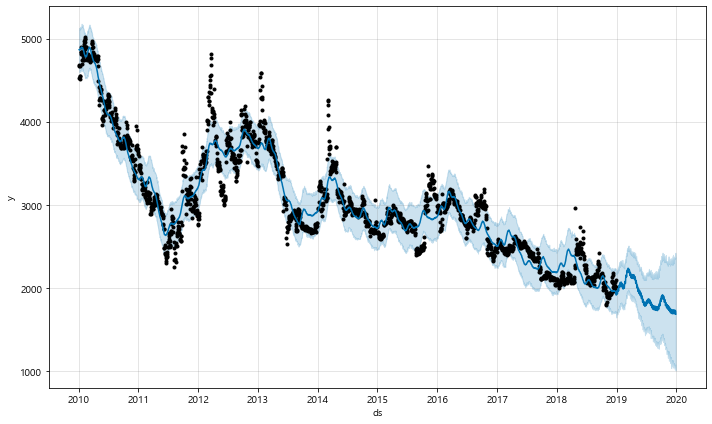

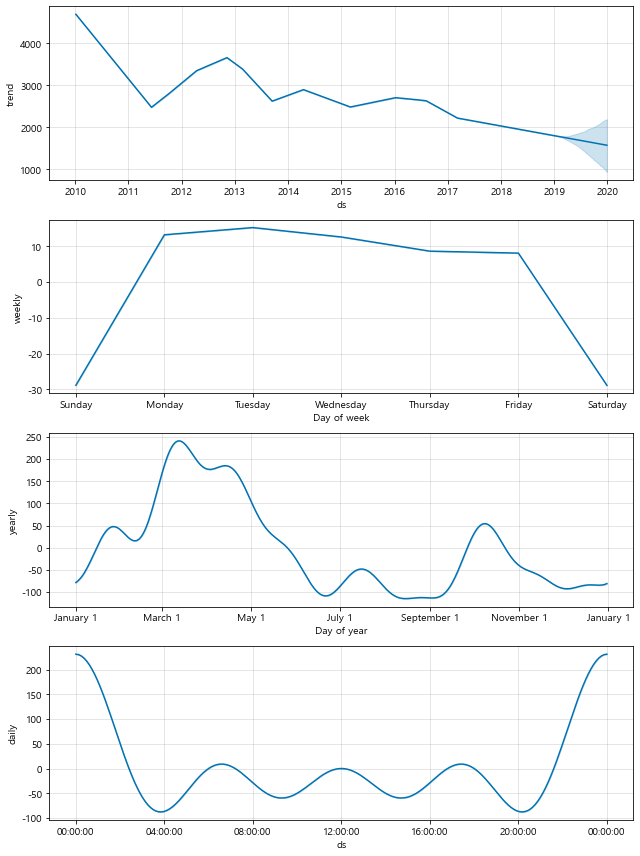

In [186]:
m=Prophet(daily_seasonality=True)
m.fit(f)
future=m.make_future_dataframe(periods=365)
#future.tail()
forecast=m.predict(future)
m.plot(forecast);
m.plot_components(forecast);

# 4. 향후 700일 간의 데이터를 예측하고, 실제 데이터와 예측값을 그래프로 그리시오

## - 2018/12/31일까지의 실제 데이터와 예측데이터 비교

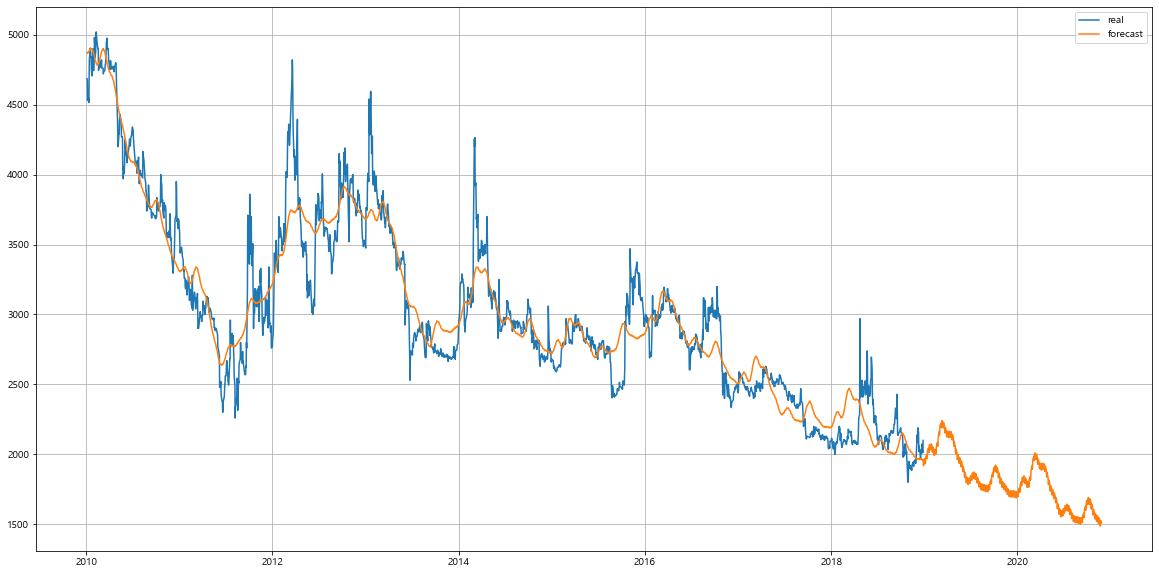

In [188]:
m=Prophet(daily_seasonality=True)
m.fit(f)
future=m.make_future_dataframe(periods=700)
forecast=m.predict(future)
plt.figure(figsize=(20,10))
plt.plot(df.index, df['종가'], label='real')
plt.plot(forecast['ds'], forecast['yhat'], label='forecast')
plt.grid()
plt.legend()
plt.show()

## - 20/06/04 현재까지의 실제 주가 데이터와 예측데이터 비교

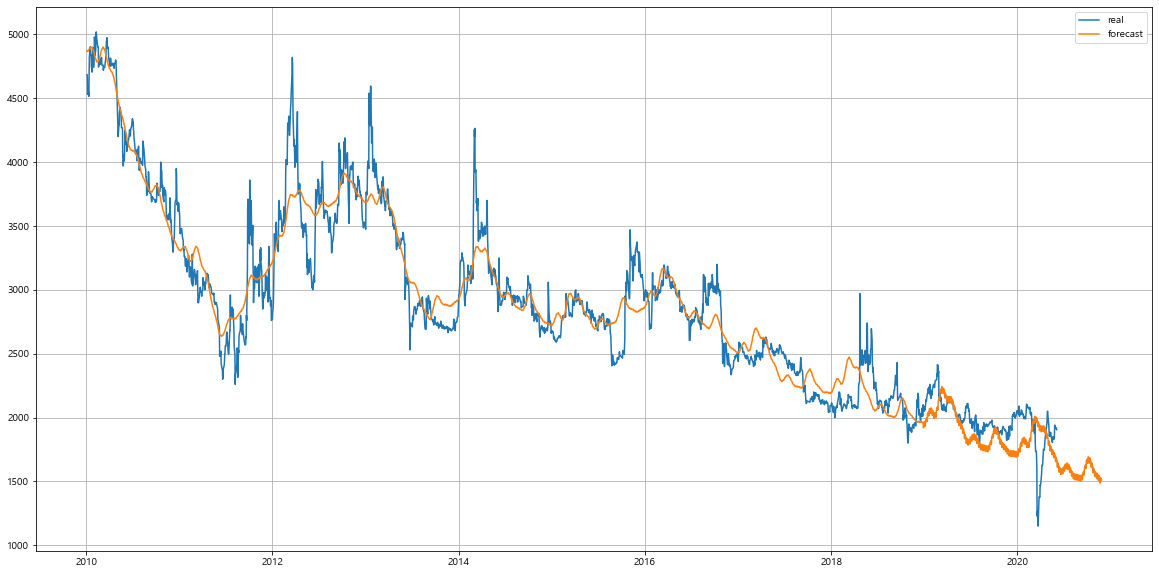

In [197]:
m=Prophet(daily_seasonality=True)
m.fit(f)
future=m.make_future_dataframe(periods=700)
forecast=m.predict(future)
plt.figure(figsize=(20,10))
plt.plot(df_origin.index, df_origin['종가'], label='real')
plt.plot(forecast['ds'], forecast['yhat'], label='forecast')
plt.grid()
plt.legend()
plt.show()

# 5.종목 토론실의 주요 키워드를 워드 클라우드로 그려보자

In [ ]:
import requests
from urllib.request import urlopen

def craling(numpage):
    all_text = []
    for i in tqdm_notebook(range(numpage+1)):
        url="https://finance.naver.com/item/board.nhn?code=040300&page={num}"
        html = urlopen(url.format(num = i))
        soup = BeautifulSoup(html,'html.parser')
        a = soup.find_all('td', {'class':'title'})
        print(a)
        for i in a:
            print(i.find('a')['title'])
            all_text.append(i.find('a')['title'])
    return all_text
            

In [ ]:
craling(10)

In [ ]:
url="https://finance.naver.com/item/board.nhn?code=005930"
html = urlopen(url.format())
soup = BeautifulSoup(html,'html.parser')
a = soup.find_all()

## 종목토론실의 url를 받아올수 없다.